# Predicting Bitcoin Prices with NNs

In this project, I'll build a neural network to predict the price of bitcoin.
To do this, I'll use the Open, Close, High, Low, and Volume values from a dataset I found on Kaggle.

In [94]:
# importing

import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Now that everything's imported, I can start to import my data. For this project, the dataset is very large (nearly 400MB), and waaaay over GitHub's 30MB file size limit. To get around this, I've run the entire NN on my own device instead of Google Colab. If you want to run this on your own, you can find the dataset [here](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data). It's also got over 7,000,000 rows, so I'll need to trim that down. In order to trim this down, I'll only choose rows that have over 200 volume. Why 200? When I looked at the original data, I saw that most of the entries remained below 200 volume, so I was able to eliminate a *lot* of unnecessary data. (brought it from 7M -> 5M rows with volume > 1, and from 5M -> 13,000 with volume > 200) This should significantly help my model to run faster.

In [95]:
df = pd.read_csv("btcusd_1-min_data.csv").dropna()
#drops all the non-numerical columns

# We won't be needing the timestamps in the NN, and it's not numerical.
df.drop(columns=["Timestamp"],inplace=True)

df.query("Volume > 200", inplace=True) # Brings our row count from 7,000,000+ to just over 13,000.
df.reset_index(drop=True,inplace=True)

df

,Open,High,Low,Close,Volume
0,5.37,5.37,5.37,5.37,213.465156
1,5.33,5.33,5.33,5.33,247.560124
2,5.32,5.32,5.32,5.32,233.772116
3,4.90,4.90,4.90,4.90,233.890000
4,5.12,5.12,5.12,5.12,233.520000
...,...,...,...,...,...
13566,26882.00,27190.00,26870.00,27075.00,210.505204
13567,33175.00,33175.00,32873.00,32887.00,200.290325
13568,46070.00,46070.00,44903.00,45643.00,339.941471
13569,62119.00,62530.00,61971.00,62393.00,233.090748


My first time through, I made this model:

In [96]:
shoot = df[["Open","High","Low","Close","Volume"]]

#convert to numpy array
s_matrix = shoot.to_numpy()
#convert to a PyTorch tensor
s_tensor = torch.from_numpy(s_matrix)

#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(in_features=2, # in_features: must match column number of input
                         out_features=1,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type

X = s_tensor[:,[1,2]] #use 3PA and FT% to predict
y_pred = linear(X) #the actual matrix multiplication
print(f"Input shape: {X.shape}\n")
print(f"Output:\n{y_pred}\n\nOutput shape: {y_pred.shape}")

X = s_tensor[:,2].unsqueeze(dim=1) #use FT% as a predictor
y = s_tensor[:,0].unsqueeze(dim=1) #FG% is the estimand, the thing we're predicting.

# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(
    in_features=1, # in_features: must match number of columns of input, which is now one
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type

# Create a loss function
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent

# Set the number of epochs; this is how many times we update our model
epochs = 10

for epoch in range(epochs):
    ### Training
    #this allows our matrices to update
    linear.train()
    # 1. Forward pass; makes predictions
    y_pred = linear(X_train)
    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()
    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()
    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()
    ### Testing
    linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)
    # Print out what's happening
    if epoch % 1 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Input shape: torch.Size([13571, 2])

Output:
tensor([[2.7933e+00],
        [2.7675e+00],
        [2.7610e+00],
        ...,
        [2.9665e+04],
        [4.0292e+04],
        [6.2029e+04]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

Output shape: torch.Size([13571, 1])
Epoch: 0 | Train loss: 55386828.51582, Test loss: 817501361313578745856.00000
Epoch: 1 | Train loss: 668130026742748807168.00000, Test loss: 9862384608431036967817359602483200.00000
Epoch: 2 | Train loss: 8060360014876026943691928612372480.00000, Test loss: 118980389096827792977166417950862398601115467776.00000
Epoch: 3 | Train loss: 97240658208626681239687741803690121206228320256.00000, Test loss: 1435386425462542279385225043254206663385636574030832376741888.00000
Epoch: 4 | Train loss: 1173117030926122753649028844273178063140717156000652121341952.00000, Test loss: 17316586422703717248329872569560672971294784764467707805919046360801214464.00000
Epoch: 5 | Train loss: 14152552991736452380036353934215756057227503958

As we can see, it looks horrible! Then, I found out I forgot to normalize my data. (thanks Grant!) So, I added some new code to normalize it. Now, I'll continue going through each step of making the NN.

In [97]:
# Alternative way to normalize the data, stolen from GeeksForGeeks (source at the bottom)

z_scaled = df.copy()

for column in z_scaled.columns:
    z_scaled[column] = (z_scaled[column] - z_scaled[column].mean()) / z_scaled[column].std()

shoot = z_scaled[["Open","High","Low","Close","Volume"]]

This code is just setting all the data up to make the NN, and is identical to what we used in the NN where I forgot to normalize the data.

In [98]:
#convert to numpy array
s_matrix = shoot.to_numpy()
#convert to a PyTorch tensor
s_tensor = torch.from_numpy(s_matrix)

In [99]:
s_tensor #the default data type is a float

tensor([[-4.2245e-01, -4.2206e-01, -4.2482e-01, -4.2344e-01, -5.9415e-01],
        [-4.2246e-01, -4.2207e-01, -4.2483e-01, -4.2345e-01, -4.3966e-01],
        [-4.2246e-01, -4.2208e-01, -4.2483e-01, -4.2345e-01, -5.0213e-01],
        ...,
        [ 1.1179e+01,  1.1117e+01,  1.1033e+01,  1.1119e+01, -2.1062e-02],
        [ 1.5221e+01,  1.5241e+01,  1.5388e+01,  1.5356e+01, -5.0522e-01],
        [ 2.3857e+01,  2.3728e+01,  2.3075e+01,  2.3086e+01, -8.7847e-02]],
       dtype=torch.float64)

In [100]:
#copied from pytorch fundamentals' online textbook

#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(in_features=4, # in_features: must match column number of input
                         out_features=3,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type

X = s_tensor[:,[0,1,2,4]] #use everything but close to predict
y_pred = linear(X) #the actual matrix multiplication
print(f"Input shape: {X.shape}\n")
print(f"Output:\n{y_pred}\n\nOutput shape: {y_pred.shape}")

Input shape: torch.Size([13571, 4])

Output:
tensor([[  0.3059,   0.3355,  -0.2668],
        [  0.2597,   0.3175,  -0.3033],
        [  0.2784,   0.3248,  -0.2885],
        ...,
        [  8.5967,  -6.2732,   7.6564],
        [ 11.6901,  -8.6270,  10.7057],
        [ 17.9166, -13.1920,  16.2854]], dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

Output shape: torch.Size([13571, 3])


All I've changed is the predictors and estimands here, otherwise it's identical to the notes.

In [101]:
X = s_tensor[:,4].unsqueeze(dim=1) #use FT% as a predictor
y = s_tensor[:,3].unsqueeze(dim=1) #FG% is the estimand, the thing we're predicting.

# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [102]:
#this function defaults to a random  offset vector and weight matrix
linear = torch.nn.Linear(
    in_features=1, # in_features: must match number of columns of input, which is now one
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type

In [103]:
# Create a loss function
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent

Now that everything for our neural network has been prepared, we're all good to start modeling this. I'll be using 10 epochs, since that's what the notes recommended.

In [104]:
# Set the number of epochs; this is how many times we update our model
epochs = 10

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    linear.train()

    # 1. Forward pass; makes predictions
    y_pred = linear(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 1 == 0: #prints every 100 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")


Epoch: 0 | Train loss: 1.80235, Test loss: 1.51986
Epoch: 1 | Train loss: 1.50583, Test loss: 1.33622
Epoch: 2 | Train loss: 1.31617, Test loss: 1.21953
Epoch: 3 | Train loss: 1.19486, Test loss: 1.14553
Epoch: 4 | Train loss: 1.11727, Test loss: 1.09870
Epoch: 5 | Train loss: 1.06764, Test loss: 1.06914
Epoch: 6 | Train loss: 1.03590, Test loss: 1.05056
Epoch: 7 | Train loss: 1.01560, Test loss: 1.03894
Epoch: 8 | Train loss: 1.00261, Test loss: 1.03171
Epoch: 9 | Train loss: 0.99431, Test loss: 1.02725


This looks promising! Let's check the final graph and results from this NN.

In [105]:
shoot

,Open,High,Low,Close,Volume
0,-0.422449,-0.422065,-0.424822,-0.423439,-0.594147
1,-0.422460,-0.422075,-0.424832,-0.423449,-0.439657
2,-0.422462,-0.422077,-0.424835,-0.423452,-0.502133
3,-0.422568,-0.422183,-0.424942,-0.423558,-0.501599
4,-0.422512,-0.422127,-0.424886,-0.423502,-0.503275
...,...,...,...,...,...
13566,6.346376,6.387903,6.430852,6.423038,-0.607559
13567,7.931255,7.887193,7.962778,7.893015,-0.653845
13568,11.178835,11.117494,11.032754,11.119275,-0.021062
13569,15.220743,15.240856,15.388393,15.355701,-0.505220


In [106]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

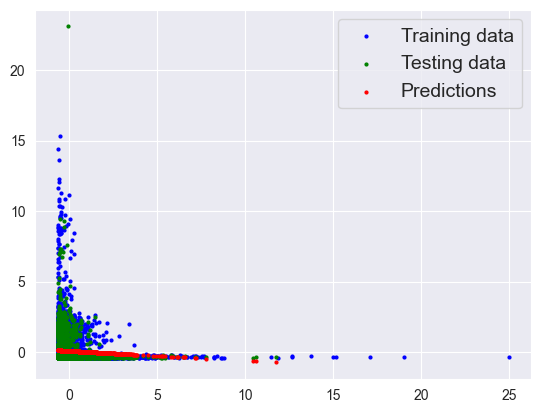

In [107]:
# Turn on evaluation mode
linear.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = linear(X_test)

# Plot data and predictions
plot_predictions(predictions=y_preds);

Interesting.. I'll try making a multi-layered NN using the code from the Unit9Notes. There's not too much to say here, so I'll just show all the code to get to the model and analyze both models in the conclusion section.

In [108]:
df2 = pd.read_csv("btcusd_1-min_data.csv")

#just gonna trim off some unnecessary data here

# We won't be needing the timestamps in the NN, and it's not numerical.
df2.drop(columns=["Timestamp"],inplace=True)

df2.query("Volume > 200", inplace=True) # Brings our row count from 7,000,000+ to just over 13,000.
df2.reset_index(drop=True,inplace=True)

#convert to a PyTorch tensor
h = df2.Volume.to_numpy() #just gonna use volume to predict
height = torch.from_numpy(h)
w = df2.Close.to_numpy()
weight = torch.from_numpy(w)

In [109]:
X = height.unsqueeze(dim=1) #use height as a predictor
y = weight.unsqueeze(dim=1) #weight is the estimand, the thing we're predicting.

In [110]:
# Scale the height using standardization
scaler = StandardScaler()
height_scaled = scaler.fit_transform(
    height.reshape(-1, 1) #makes it a column vector
    )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    height_scaled, weight, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

/var/folders/_z/2t3c57x51dx053zg79bk54vr0000gn/T/ipykernel_49768/4067959083.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/var/folders/_z/2t3c57x51dx053zg79bk54vr0000gn/T/ipykernel_49768/4067959083.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [111]:
# Two layer nn with nn.Sequential
model_00 = nn.Sequential(
    #out_features is 7, for 7 nodes/neurons/knots
    nn.Linear(in_features=1, out_features=7),
    #in_features is 7, for 7 nodes/neurons/knots
    nn.Linear(in_features=7, out_features=1),
)

In [112]:
# Create a loss function
# different loss functions work better for different data sets
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
#Adam is another similar, popular optimizer
optimizer = torch.optim.SGD(params=model_00.parameters(),
                            lr=0.0001) #this is how fast it optimizes; smaller is slower, but more consistent

Model time!

In [113]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_00.train()

    # 1. Forward pass; makes predictions
    y_pred = model_00(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_00.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_00(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 200 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2715])) that is different to the input size (torch.Size([2715, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 18579588.00000, Test loss: 17940910.00000
Epoch: 200 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 400 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 600 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 800 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 1000 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 1200 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 1400 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 1600 | Train loss: 15578185.00000, Test loss: 15279790.00000
Epoch: 1800 | Train loss: 15578185.00000, Test loss: 15279790.00000


Oop.. That doesn't look good. Maybe I'll stick to the single-layered neural network.

## Conclusion

The single-layered neural network performed better than the multi-layered one. My best guess as to why is that the  multi-layered model was only able to use one predictor, while I was able to use 4 on the single-layered model. I didn't have enough time to tweak the mult-layered model to improve it, so this is the best NN I'll have for this project. If I were to redo this, I'd spend more time on the multi-layered model to further improve it. The single-layered NN didn't end up as bad as I'd expected though, so I'm overall happy with this project.

## Sources

Stole some normalization code from [here](https://www.geeksforgeeks.org/data-normalization-with-pandas/).